In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# import essential modules
import os

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import pandas as pd
import numpy as np


In [3]:
# some useful utils funcion to load data

def process_read_dataframe(df: pd.DataFrame):
    bins = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    # group
    df["unique_id_question_body"] = df["question_body"].astype("category").cat.codes
    df["unique_id_question_body"] = df["category"].str.cat(df["unique_id_question_body"].astype("str"), sep="_")
    df["host_stem"] = df["host"].str.split(".").apply(lambda x: ".".join(x[-2:]))
    group_columns = ["category", "host_stem", "unique_id_question_body"]
    df[group_columns] = df[group_columns].astype("category")

    # corpus
    columns = ["question_title", "question_body", "answer"]
    for col in columns:
        df[f"count_{col}"] = df[col].str.split(" ").apply(lambda x: len(x)).astype(np.int32)

    df["count_question_title_body"] = (df["count_question_title"] + df["count_question_body"]).astype(np.int32)
    df["count_question_title_body_answer"] = (df["count_question_title_body"] + df["count_answer"]).astype(np.int32)
    stats_columns = [f"count_{col}" for col in columns] + [
        "count_question_title_body", "count_question_title_body_answer"]

    df_stats = df[stats_columns].describe(bins)
    df_stats_split = df.groupby("category")[stats_columns].apply(lambda x: x.describe(bins)).unstack(0).T

    # concat
    # df["question_title_body"] = df["question_title"].str.cat(others=df["question_body"], sep=" ")
    # columns = columns + ["question_title_body"]
    return df[columns], df[group_columns], df_stats, df_stats_split


In [4]:
# data folder
data_dir = '../input/google-quest-challenge'
index_name = 'qa_id'

## Tasks to predict

In [5]:
target_columns = [
    "question_asker_intent_understanding", "question_body_critical", "question_conversational",
    "question_expect_short_answer", "question_fact_seeking", "question_has_commonly_accepted_answer",
    "question_interestingness_others", "question_interestingness_self", "question_multi_intent",
    "question_not_really_a_question", "question_opinion_seeking", "question_type_choice", "question_type_compare",
    "question_type_consequence", "question_type_definition", "question_type_entity", "question_type_instructions",
    "question_type_procedure", "question_type_reason_explanation", "question_type_spelling",
    "question_well_written", "answer_helpful", "answer_level_of_information", "answer_plausible",
    "answer_relevance", "answer_satisfaction", "answer_type_instructions", "answer_type_procedure",
    "answer_type_reason_explanation", "answer_well_written"
]

# split by questioin and answer
output_categories_question = list(filter(lambda x: x.startswith("question_"), target_columns))
output_categories_answer = list(filter(lambda x: x.startswith("answer_"), target_columns))
output_categories = output_categories_question + output_categories_answer

In [6]:
# training
df_train = pd.read_csv(os.path.join(data_dir, "train.csv")).set_index(index_name)

# labels
df_train[target_columns] = df_train[target_columns].astype(np.float32)
train_y = df_train[output_categories]
train_x, train_groups, train_stats, train_stats_split = process_read_dataframe(df_train)
train_x.shape  # training data size

(6079, 3)

In [7]:
# looking for the ratio of duplicated questions
df_train["question_body"].nunique() / df_train.shape[0] 

0.5894061523276855

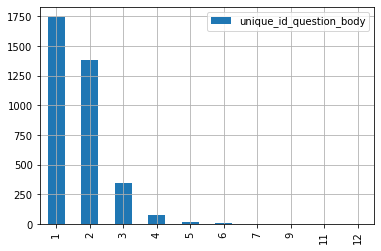

In [8]:
# Frequency of duplicated questions, ~1750 question bodies don't have any dupplicates, and over 1250 with duplicated once, and some even have 12.
train_groups["unique_id_question_body"].value_counts().value_counts().sort_index().plot(kind="bar", legend="distribution of duplicated distribution", grid=True)

In [9]:
df_train.groupby("category").apply(lambda x: x["question_body"].nunique() / len(x))  # duplicated among different categories

category
CULTURE          0.547248
LIFE_ARTS        0.548660
SCIENCE          0.577840
STACKOVERFLOW    0.605746
TECHNOLOGY       0.612864
dtype: float64

In [10]:
# get stats of setence length by words of question and answer pair: ["question_title", "question_body", "answer"]
train_stats.T  # half of the context of question_body and answer are less 100 words (93, 91 words on question_body and answer,respectively). 

# 95% of them are less than 440 words, this provide a good insights to set the input max_lengh for language model.

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
count_question_title,6079.0,9.035861,3.775760,2.0,6.0,9.0,11.0,14.0,16.0,20.00,28.0
count_question_body,6079.0,150.440204,228.709619,1.0,55.0,93.0,165.0,283.0,433.0,1026.72,4666.0
count_answer,6079.0,143.708834,205.933584,2.0,48.0,91.0,170.0,294.0,428.2,882.44,8158.0
count_question_title_body,6079.0,159.476065,228.671785,8.0,63.0,103.0,175.0,293.0,440.1,1033.16,4674.0
count_question_title_body_answer,6079.0,303.184899,323.834214,17.0,142.0,222.0,349.0,556.2,779.1,1545.98,8246.0


In [11]:
train_stats_split  # Further split by category. There are five categories: CULTURE, LIFE_ARTS, SCIENCE, STACKOVERFLOW and TECHNOLOGY.

count        mean  \
                                 category                            
count_question_title             CULTURE         963.0    9.620976   
                                 LIFE_ARTS       709.0   10.396333   
                                 SCIENCE         713.0    8.723703   
                                 STACKOVERFLOW  1253.0    8.569832   
                                 TECHNOLOGY     2441.0    8.740270   
count_question_body              CULTURE         963.0  101.056075   
                                 LIFE_ARTS       709.0  126.078984   
                                 SCIENCE         713.0  115.976157   
                                 STACKOVERFLOW  1253.0  204.482841   
                                 TECHNOLOGY     2441.0  159.324457   
count_answer                     CULTURE         963.0  157.057113   
                                 LIFE_ARTS       709.0  173.454161   
                                 SCIENCE         713.0  155.702665   
                                 STACKOVERFLOW  1253.0  112.813248   
                                 TECHNOLOGY     2441.0  142.158951   
count_question_title_body        CULTURE         963.0  110.677051   
                                 LIFE_ARTS       709.0  136.475317   
                                 SCIENCE         713.0  124.699860   
                                 STACKOVERFLOW  1253.0  213.052674   
                                 TECHNOLOGY     2441.0  168.064728   
count_question_title_body_answer CULTURE         963.0  267.734164   
                                 LIFE_ARTS       709.0  309.929478   
                                 SCIENCE         713.0  280.402525   
                                 STACKOVERFLOW  1253.0  325.865922   
                                 TECHNOLOGY     2441.0  310.223679   

                                                       std   min    25%  \
                                 category                                 
count_question_title             CULTURE          3.947506   3.0    7.0   
                                 LIFE_ARTS        3.765670   2.0    8.0   
                                 SCIENCE          4.293412   2.0    6.0   
                                 STACKOVERFLOW    3.486526   2.0    6.0   
                                 TECHNOLOGY       3.568954   2.0    6.0   
count_question_body              CULTURE         91.602146  10.0   47.0   
                                 LIFE_ARTS      107.678361   9.0   56.0   
                                 SCIENCE         98.891643   8.0   53.0   
                                 STACKOVERFLOW  254.435027  10.0   68.0   
                                 TECHNOLOGY     290.678321   1.0   54.0   
count_answer                     CULTURE        188.746962   3.0   51.0   
                                 LIFE_ARTS      165.444256   6.0   69.0   
                                 SCIENCE        159.202961   5.0   61.0   
                                 STACKOVERFLOW  172.324005   2.0   35.0   
                                 TECHNOLOGY     245.267146   2.0   48.0   
count_question_title_body        CULTURE         91.645381  18.0   57.0   
                                 LIFE_ARTS      107.892201  18.0   67.0   
                                 SCIENCE         99.169938  13.0   61.0   
                                 STACKOVERFLOW  254.537469  17.0   76.0   
                                 TECHNOLOGY     290.615632   8.0   63.0   
count_question_title_body_answer CULTURE        223.500566  21.0  129.0   
                                 LIFE_ARTS      215.846797  52.0  164.0   
                                 SCIENCE        200.995966  31.0  152.0   
                                 STACKOVERFLOW  326.611042  42.0  144.0   
                                 TECHNOLOGY     400.640959  17.0  138.0   

                                                  50%    75%    90%    95%  \
                                 category             

The distribution on

In [12]:
train_y.describe().T

,count,mean,std,min,25%,50%,75%,max
question_asker_intent_understanding,6079.0,0.892663,0.132047,0.333333,0.777778,0.888889,1.000000,1.000000
question_body_critical,6079.0,0.595301,0.219470,0.333333,0.444444,0.555556,0.777778,1.000000
question_conversational,6079.0,0.057301,0.182196,0.000000,0.000000,0.000000,0.000000,1.000000
question_expect_short_answer,6079.0,0.698525,0.350938,0.000000,0.500000,0.666667,1.000000,1.000000
question_fact_seeking,6079.0,0.772632,0.303023,0.000000,0.666667,1.000000,1.000000,1.000000
question_has_commonly_accepted_answer,6079.0,0.793689,0.336622,0.000000,0.666667,1.000000,1.000000,1.000000
question_interestingness_others,6079.0,0.587478,0.135900,0.333333,0.444444,0.555556,0.666667,1.000000
question_interestingness_self,6079.0,0.507275,0.185987,0.333333,0.333333,0.444444,0.666667,1.000000
question_multi_intent,6079.0,0.238745,0.335057,0.000000,0.000000,0.000000,0.333333,1.000000
question_not_really_a_question,6079.0,0.004469,0.045782,0.000000,0.000000,0.000000,0.000000,1.000000


## Unique values in Values

Although these labels are averaged be several scorer, most labels are just a few unique values. This provide the insights for postprocessing after prediciont.

In [13]:
train_y.nunique()  # observe how many unique values within labels: 

question_asker_intent_understanding       9
question_body_critical                    9
question_conversational                   5
question_expect_short_answer              5
question_fact_seeking                     5
question_has_commonly_accepted_answer     5
question_interestingness_others           9
question_interestingness_self             9
question_multi_intent                     5
question_not_really_a_question            5
question_opinion_seeking                  5
question_type_choice                      5
question_type_compare                     5
question_type_consequence                 5
question_type_definition                  5
question_type_entity                      5
question_type_instructions                5
question_type_procedure                   5
question_type_reason_explanation          5
question_type_spelling                    3
question_well_written                     9
answer_helpful                            9
answer_level_of_information     

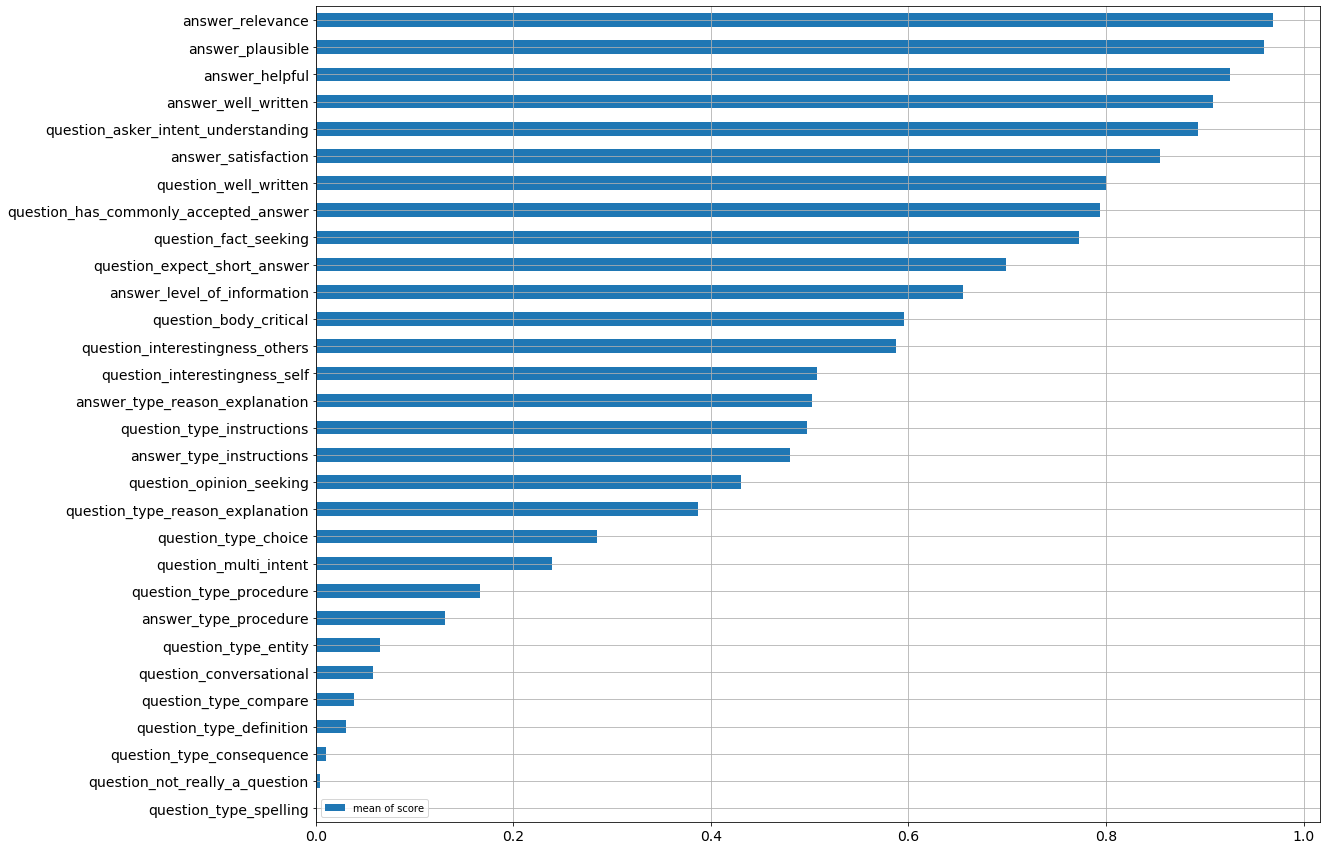

In [14]:
train_y.mean().rename('mean of score').sort_values().plot(kind='barh', figsize=(18, 15), grid=True, fontsize=14, legend='Mean value of each target')

Here is . It can be foresee that on the bottom side, such as `question_type_consequnce`, `question_not_really_a_question`, `question_type_spelling` would suffer in modeling as their minor representation.

In [15]:
train_y.corr().abs().describe([.99]).T  #labels has very weak correaltion among each other. The max 1.0 is correlation with label theirselves.

,count,mean,std,min,50%,99%,max
question_asker_intent_understanding,30.0,0.123495,0.178155,0.024867,0.069181,0.788815,1.0
question_body_critical,30.0,0.128699,0.186683,0.002452,0.079896,0.822570,1.0
question_conversational,30.0,0.143353,0.198128,0.002833,0.081231,0.829497,1.0
question_expect_short_answer,30.0,0.129911,0.178346,0.006587,0.090485,0.804818,1.0
question_fact_seeking,30.0,0.140763,0.213207,0.004669,0.083385,0.909084,1.0
question_has_commonly_accepted_answer,30.0,0.146823,0.201768,0.006054,0.070113,0.828290,1.0
question_interestingness_others,30.0,0.119687,0.199256,0.001221,0.056185,0.875924,1.0
question_interestingness_self,30.0,0.153489,0.206057,0.003517,0.088295,0.875924,1.0
question_multi_intent,30.0,0.115776,0.182184,0.001806,0.061869,0.796902,1.0
question_not_really_a_question,30.0,0.055390,0.179597,0.000347,0.016286,0.730983,1.0


## Test stats

Also load test set to exam

In [16]:
df_test = pd.read_csv(os.path.join(data_dir, "test.csv")).set_index(index_name)
test_x, test_groups, test_stats, test_stats_split = process_read_dataframe(df_test)

In [17]:
test_stats.T 

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
count_question_title,476.0,8.789916,3.547866,2.0,6.00,9.0,11.00,13.0,15.00,17.00,29.0
count_question_body,476.0,164.989496,377.735978,9.0,52.00,88.0,158.00,285.5,430.00,1214.25,6853.0
count_answer,476.0,159.745798,221.058288,2.0,50.00,92.0,181.00,354.5,475.00,1190.75,2374.0
count_question_title_body,476.0,173.779412,377.592043,16.0,60.00,96.5,166.25,295.5,438.25,1220.00,6862.0
count_question_title_body_answer,476.0,333.525210,468.835262,32.0,142.75,224.5,359.75,587.0,879.00,1765.00,7141.0


In [18]:
test_stats_split

count        mean         std  \
                                 category                                       
count_question_title             CULTURE         64.0    9.015625    3.387616   
                                 LIFE_ARTS       47.0    9.957447    4.267967   
                                 SCIENCE         58.0    8.810345    3.634421   
                                 STACKOVERFLOW  103.0    8.388350    3.284643   
                                 TECHNOLOGY     204.0    8.647059    3.492842   
count_question_body              CULTURE         64.0   87.390625   78.695640   
                                 LIFE_ARTS       47.0   96.595745   57.104656   
                                 SCIENCE         58.0  130.172414  101.924661   
                                 STACKOVERFLOW  103.0  188.242718  254.407249   
                                 TECHNOLOGY     204.0  203.250000  539.161876   
count_answer                     CULTURE         64.0  181.921875  205.375638   
                                 LIFE_ARTS       47.0  160.127660  113.738185   
                                 SCIENCE         58.0  195.275862  207.372518   
                                 STACKOVERFLOW  103.0  118.669903  171.312259   
                                 TECHNOLOGY     204.0  163.338235  264.794387   
count_question_title_body        CULTURE         64.0   96.406250   79.203319   
                                 LIFE_ARTS       47.0  106.553191   58.139565   
                                 SCIENCE         58.0  138.982759  102.738724   
                                 STACKOVERFLOW  103.0  196.631068  254.121786   
                                 TECHNOLOGY     204.0  211.897059  538.965534   
count_question_title_body_answer CULTURE         64.0  278.328125  236.322355   
                                 LIFE_ARTS       47.0  266.680851  143.422924   
                                 SCIENCE         58.0  334.258621  240.384090   
                                 STACKOVERFLOW  103.0  315.300971  303.330979   
                                 TECHNOLOGY     204.0  375.235294  652.658748   

                                                 min     25%    50%     75%  \
                                 category                                     
count_question_title             CULTURE         3.0    6.00    9.0   11.00   
                                 LIFE_ARTS       3.0    7.50   10.0   12.00   
                                 SCIENCE         2.0    6.00    8.5   11.75   
                                 STACKOVERFLOW   2.0    6.00    8.0   11.00   
                                 TECHNOLOGY      3.0    6.00    8.0   11.00   
count_question_body              CULTURE        10.0   38.50   62.5  142.75   
                                 LIFE_ARTS      14.0   50.50   85.0  137.50   
                                 SCIENCE        17.0   70.25   86.5  171.00   
                                 STACKOVERFLOW  12.0   56.50  104.0  196.50   
                                 TECHNOLOGY      9.0   53.00  101.0  164.25   
count_answer                     CULTURE        20.0   64.75  110.0  198.00   
                                 LIFE_ARTS      18.0   70.00  143.0  204.00   
                                 SCIENCE         7.0   71.50  134.5  245.75   
                                 STACKOVERFLOW   2.0   36.50   67.0  151.00   
                                 TECHNOLOGY      5.0   46.75   83.5  163.50   
count_question_title_body        CULTURE        16.0   46.75   74.5  148.25   
                                 LIFE_ARTS      25.0   60.00   97.0  146.50   
                                 SCIENCE        26.0   77.25   94.5  179.75   
                                 STACKOVERFLOW  19.0   64.50  114.0  208.00   
                                 TECHNOLOGY     18.0   62.75  107.0  177.75   
count_question_title_body_answer CULTURE        56.0  125.00  201.0  348.25   
                                 LIFE_ARTS 

## Distribution difference between training and test set

It appears that the mean paragraph length of training set are shorter than test set except question title. Mean length of answer are shorter 10% than test set have. However, once split data into the provided cateories such as `CULTURE`, `LIFE_ARTS`, `SCIENCE`, `STACKOVERFLOW` and `TECHNOLOGY`, then training corpus are longer at `LIFE_ARTS` and `STACKOVERFLOW`.

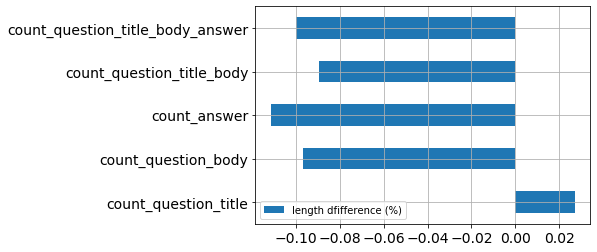

In [19]:
((train_stats.T['mean'] - test_stats.T['mean']) / train_stats.T['mean']).rename("length dfifference (%)").plot(
    kind='barh', grid=True, fontsize=14, legend='paragragh length differencec between train and test')  # seems training is generally shorter.

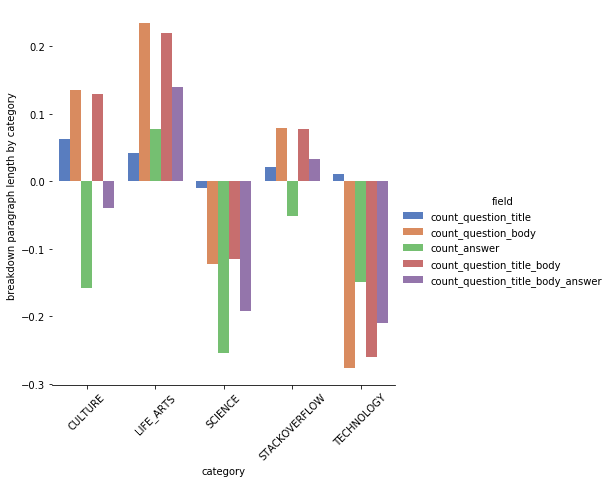

In [20]:
df = ((train_stats_split['mean'] - test_stats_split['mean']) / train_stats_split['mean']).reset_index()
df.columns = ['field'] + df.columns.tolist()[1:]

g = sns.catplot(x="category", y="mean", hue="field", data=df, height=6, kind="bar", palette="muted", )
g.despine(left=True)
g.set_ylabels("breakdown paragraph length by category")
g.set_xticklabels(rotation=45)  # upside longer on training set, and downside on longer on test set.

## To be continued with training models